# 3-parameter interpolation in the two-qubit Weyl chamber

In [1]:
import random
import sys,io,os
from scipy.spatial import Delaunay
from qctrl_optimize import hamiltonians
from qctrl_optimize import optimize as opt
from qctrl_optimize import gates
from qctrl_optimize import simulate as sim
from qctrl_optimize import interpolate as interp
from qctrl_optimize import plot as plotter
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import pickle
from itertools import product

In [2]:
from qc_utils import matplotlib_setup as mpl_setup
mpl_setup.set_font(size=16)
colors = mpl_setup.colors

In [3]:
# Set up parameters for the Interpolater

num_pwc_segments = 20
segment_count = 500
duration = np.pi
sample_times = np.linspace(0, duration, segment_count)
amplitude=1
tik0 = 1e-2
tik0 = tik0 / (amplitude**2 * num_pwc_segments)
conv_std = None

def in_weyl(pts):
    return (1 >= pts[:,0]) * (np.minimum(pts[:,0], 1-pts[:,0]) >= pts[:,1]) * (pts[:,1] >= pts[:,2]) * (pts[:,2] >= 0)

# get sets of reference points and testing points
def get_points(granularity):
    npts = int(1+1/granularity)
    points = np.array(list(product(np.linspace(0,1,npts), np.linspace(0,1,npts), np.linspace(0,1,npts))))
    points = points[in_weyl(points)]
    return points
granularity_train = 1/4
granularity_test = 1/16
train_points = get_points(granularity_train)
test_points = get_points(granularity_test)

# function mapping pulse signals to Hamiltonian
def sigs_to_ham(graph, signals):
    hamiltonian, _,_,= hamiltonians.simple_hamiltonian_from_signals(graph, signals)
    return hamiltonian

# function mapping (graph, target, signals) => graph.infidelity
infid_func = opt.get_ham_infid_func(sigs_to_ham)

var_shape = (hamiltonians.SIMPLE_HAM_N_SIG, num_pwc_segments)
# function mapping pulse optimizable variables to signal objects
vals_to_sigs = opt.get_vals_to_sigs_pwc(duration, var_shape, amplitude)

# Figure 3: infidelity vs. computational cost
Weyl chamber, varying granularities

In [4]:
from_scratch = False
num_optimization_rounds = 10
seed = 0
num_pwc_segments = 20

if from_scratch:
    from qctrl import Qctrl
    qctrl = Qctrl()

In [5]:
# Compute average interpolation infidelities for various granularities and 0 to 4 re-optimization rounds.
# This cell may take around TWO HOURS to execute if run_from_scratch = True

granularities = [1/2, 1/4, 1/6, 1/8]
test_gran = 1/24

all_means = np.zeros((len(granularities),num_optimization_rounds))
all_stds = np.zeros((len(granularities),num_optimization_rounds))
all_infids = []
all_n_iters = []

result_dicts = []

qctrl = None
test_points = get_points(test_gran)
for i,train_gran in enumerate(granularities):
    interpolater = None
    opt_var_results = None
    train_points = get_points(train_gran)
    infids_inner = []
    n_iters_inner = []
    result_dicts_inner = []
    for iter in range(num_optimization_rounds):
        filename = f'interpolation_results/weyl/gran_{i}/result_dict_{iter}.pkl'
        if from_scratch or not os.path.exists(filename):
            if qctrl is None:
                from qctrl import Qctrl
                qctrl = Qctrl()
            if interpolater is None:
                interpolater = interp.Interpolater(qctrl, gates.weyl, tik0, interp.neighbor_avg, seed, infid_func, vals_to_sigs)
            if iter > 0:
                train_points, opt_var_results = interp.sort_points_by_tik(train_points, opt_var_results)
            opt_var_results, n_iters = interpolater.train(train_points, first_run=(iter==0), all_opt_var_results=opt_var_results, max_iter=50)
            infids, simplices, _, _ = interpolater.test_interpolations(train_points, opt_var_results, test_points)

            result_dict = {'train_gran':train_gran, 'train_points':train_points, 'test_points':test_points, 'infids':infids, 'simplices':simplices, 'n_iters':n_iters, 'opt_var_results':opt_var_results}
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            pickle.dump(result_dict, open(filename, 'wb'))
        else:
            result_dict = pickle.load(open(filename, 'rb'))
            train_points = result_dict['train_points']
            test_points = result_dict['test_points']
            infids = result_dict['infids']
            simplices = result_dict['simplices']
            n_iters = result_dict['n_iters']
            opt_var_results = result_dict['opt_var_results']
        
        all_means[i,iter] = np.mean(infids)
        all_stds[i,iter] = np.std(infids)
        infids_inner.append(infids)
        n_iters_inner.append(n_iters)
        result_dicts_inner.append(result_dict)

    all_infids.append(infids_inner)
    all_n_iters.append(n_iters_inner)
    result_dicts.append(result_dicts_inner)

In [6]:
def n_weyl_pts(gran):
    return get_points(gran).shape[0]

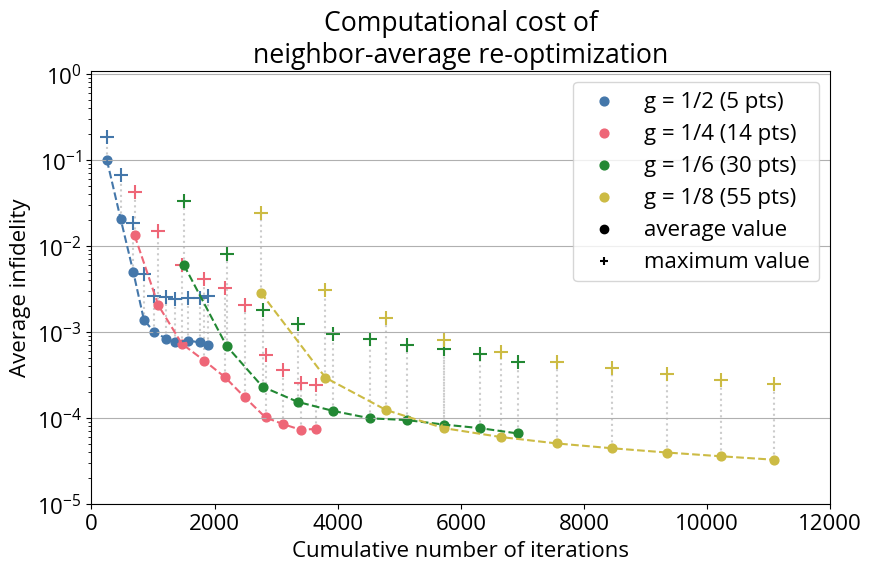

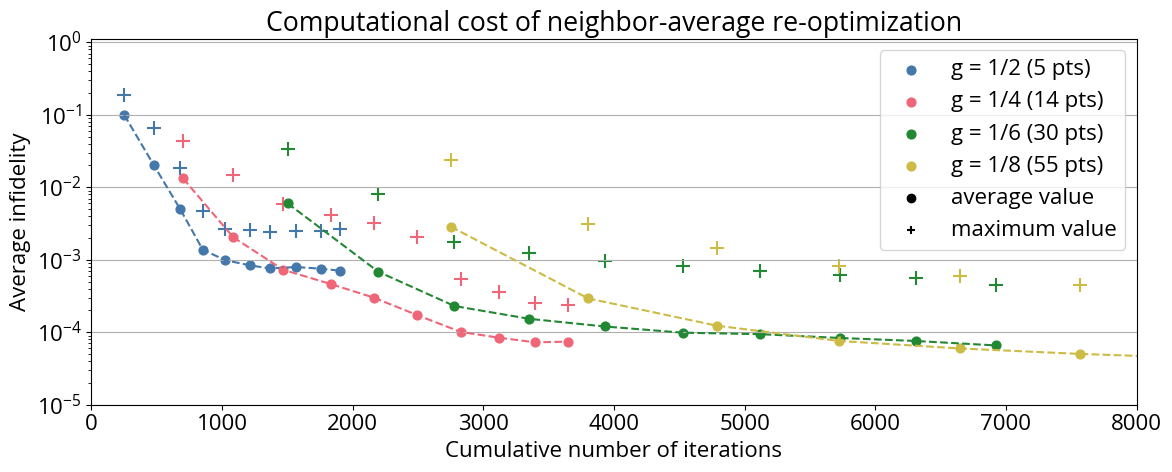

In [7]:
# Plot interpolation average infidelities as a function of total number of cost function evaluations
f,ax = plt.subplots(figsize=(9,6))


for i,train_gran in enumerate(granularities):
    n_iters_tot = [np.cumsum(np.sum(np.array(n_iterss), axis=1)) for n_iterss in all_n_iters]
    maxvals = np.max(np.array(all_infids[i]), axis=1)
    for j,m in enumerate(maxvals):
        ax.plot([n_iters_tot[i][j], n_iters_tot[i][j]], [all_means[i,j], m], ':', color="#ccc", zorder=0)
    ax.plot(n_iters_tot[i], all_means[i,:], '--', color=colors[i])
    ax.scatter(n_iters_tot[i],all_means[i,:], label=f"g = 1/{int(1/train_gran)} ({n_weyl_pts(train_gran)} pts)", color=colors[i], s=40)
    ax.scatter(n_iters_tot[i],maxvals, color=colors[i], marker='+', s=100)
ax.scatter(0,0,c='black', label='average value')
ax.scatter(0,0,c='black', marker='+', label='maximum value')
ax.grid(True, 'major', 'y')
ax.set_xlabel('Cumulative number of iterations')
ax.set_ylabel('Average infidelity')
ax.set_yscale('log')
ax.set_ylim(10**(-5), 1.1)
ax.set_xlim(0, 12000)
ax.set_title(f'Computational cost of\nneighbor-average re-optimization')

ax.legend()
plt.tight_layout()
plt.savefig('interpolation_results/weyl/iterations.pdf')
plt.savefig('interpolation_results/weyl/iterations.svg')
plt.show()

# Wide version
f,ax = plt.subplots(figsize=(12,5))

for i,train_gran in enumerate([1/2, 1/4, 1/6, 1/8]):#, 1/12]):
    n_iters_tot = [np.cumsum(np.sum(np.array(n_iterss), axis=1)) for n_iterss in all_n_iters]
    ax.plot(n_iters_tot[i], all_means[i,:], '--', color=colors[i])
    ax.scatter(n_iters_tot[i],all_means[i,:], label=f"g = 1/{int(1/train_gran)} ({n_weyl_pts(train_gran)} pts)", color=colors[i], s=40)
    maxvals = np.max(np.array(all_infids[i]), axis=1)
    ax.scatter(n_iters_tot[i],maxvals, color=colors[i], marker='+', s=100)
ax.scatter(0,0,c='black', label='average value')
ax.scatter(0,0,c='black', marker='+', label='maximum value')
ax.grid(True, 'major', 'y')
ax.set_xlabel('Cumulative number of iterations')
ax.set_ylabel('Average infidelity')
ax.set_yscale('log')
ax.set_ylim(10**(-5), 1.1)
ax.set_xlim(0, 8000)
ax.set_title(f'Computational cost of neighbor-average re-optimization')

ax.legend()
plt.tight_layout()
plt.savefig('interpolation_results/weyl/iterations-wide.pdf')
plt.savefig('interpolation_results/weyl/iterations-wide.svg')
plt.show()

In [8]:
all_means[1]

array([1.32534459e-02, 2.03842941e-03, 7.27716640e-04, 4.62742172e-04,
       2.98177752e-04, 1.72276091e-04, 1.00846732e-04, 8.41322700e-05,
       7.25480453e-05, 7.42315974e-05])

In [9]:
all_stds[1]

array([1.26838857e-02, 2.67161615e-03, 1.12981686e-03, 7.37471745e-04,
       4.92292681e-04, 2.55190723e-04, 8.27603598e-05, 6.37636979e-05,
       5.41938571e-05, 5.24314023e-05])

In [10]:
n_iters_tot[1]

array([ 701, 1086, 1468, 1832, 2166, 2494, 2828, 3119, 3398, 3650])

# Figure 4: interpolation example

Weyl chamber, granularity 1/4

In [11]:
from_scratch = False
num_optimization_rounds = 10
seed = 0 # chosen to find a good example where initial interpolation is bad (to illustrate the neighbor-average method)

if from_scratch:
    from qctrl import Qctrl
    qctrl = Qctrl()

In [12]:
result_dicts = []

if from_scratch:
    interpolater = interp.Interpolater(qctrl, gates.weyl, tik0, interp.neighbor_avg, seed, infid_func, vals_to_sigs)

opt_var_results = None
for iter in range(num_optimization_rounds):
    # filename = f'interpolation_results/weyl/result_dict_{iter}.pkl'
    filename = f'interpolation_results/weyl/gran_1/result_dict_{iter}.pkl'
    if from_scratch:
        if iter > 0:
            train_points, opt_var_results = interp.sort_points_by_tik(train_points, opt_var_results)
        opt_var_results, n_iters = interpolater.train(train_points, first_run=(iter == 0), all_opt_var_results=opt_var_results, max_iter=50)
        infids, simplices = interpolater.test_interpolations(train_points, opt_var_results, test_points)
        
        result_dict = {'train_points':train_points, 'test_points':test_points, 'infids':infids, 'simplices':simplices, 'n_iters':n_iters, 'opt_var_results':opt_var_results}
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        pickle.dump(result_dict, open(filename, 'wb'))
        
        result_dicts.append(result_dict)
    else:
        result_dicts.append(pickle.load(open(filename, 'rb')))

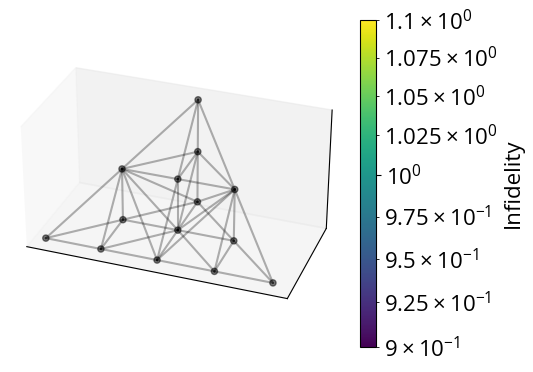

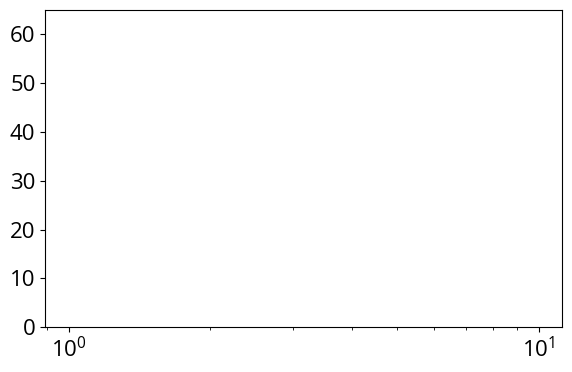

In [13]:
train_points = result_dicts[0]['train_points']
test_points = result_dicts[0]['test_points']
infids = result_dicts[0]['infids']
simplices = result_dicts[0]['simplices']

plot_file = f'interpolation_results/weyl/example_plots/train_points_'
os.makedirs(os.path.dirname(plot_file), exist_ok=True)
plotter.plot_interpolation(train_points, np.zeros(train_points.shape[0]), train_points, simplices, savepath=plot_file, aspect=(2,1,1), hist_ylim=(0,65), min_v=0)

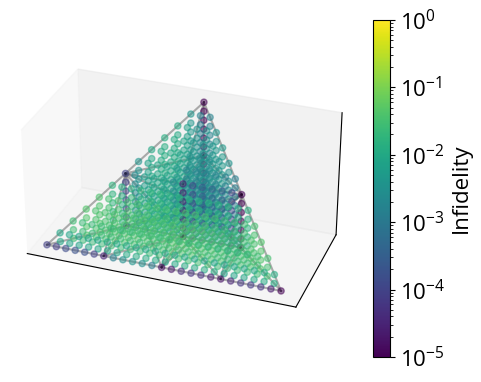

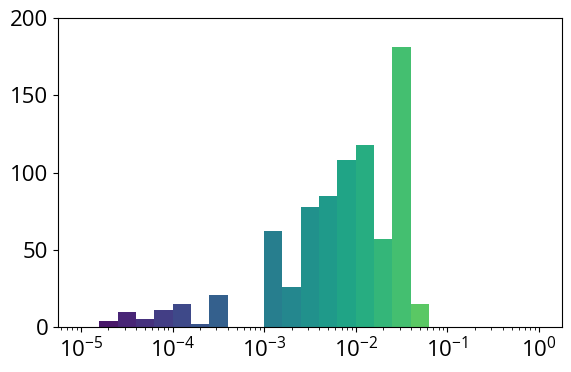

Average infidelity: 1.33e-02 +- 1.27e-02
Cumulative iterations: 701


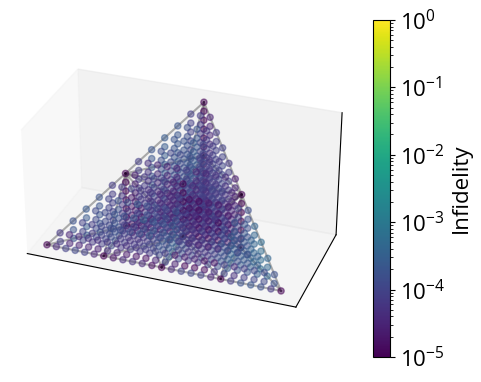

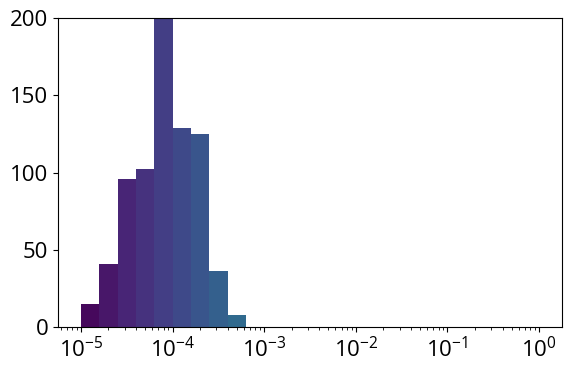

Average infidelity: 1.01e-04 +- 8.28e-05
Cumulative iterations: 1035


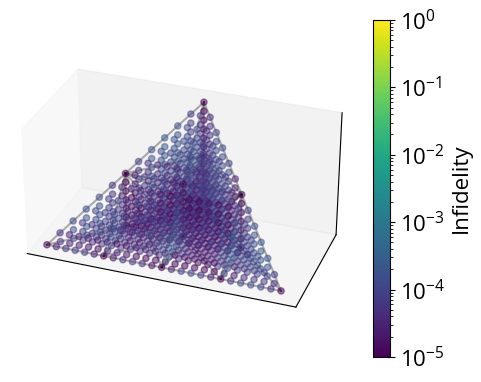

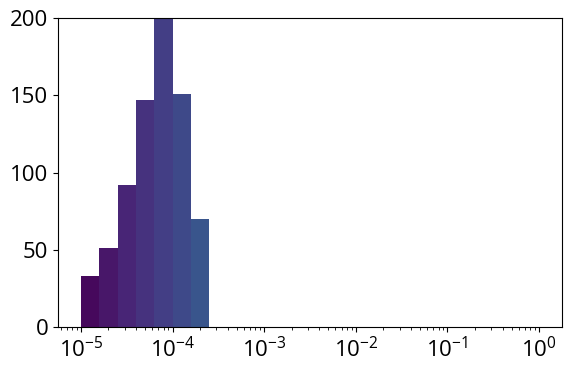

Average infidelity: 7.42e-05 +- 5.24e-05
Cumulative iterations: 1287


In [14]:
cum_iters = 0
iters_to_plot = [0,6,9]
for i,result_dict in enumerate(result_dicts):
    if i in iters_to_plot:
        plot_file = f'interpolation_results/weyl/example_plots/{i}_'
        os.makedirs(os.path.dirname(plot_file), exist_ok=True)
        plotter.plot_interpolation(result_dict['test_points'], result_dict['infids'], result_dict['train_points'], result_dict['simplices'], savepath=plot_file, aspect=(2,1,1), hist_ylim=(0,200), min_v=-5)
        cum_iters += np.sum(result_dict['n_iters'])
        print(f"Average infidelity: {np.mean(result_dict['infids']):0.2e} +- {np.std(result_dict['infids']):0.2e}")
        print(f'Cumulative iterations: {cum_iters}')

# Figure 2: pulse comparison

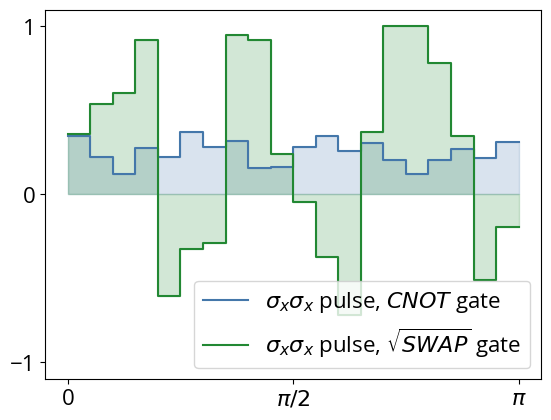

0.0386142470160189


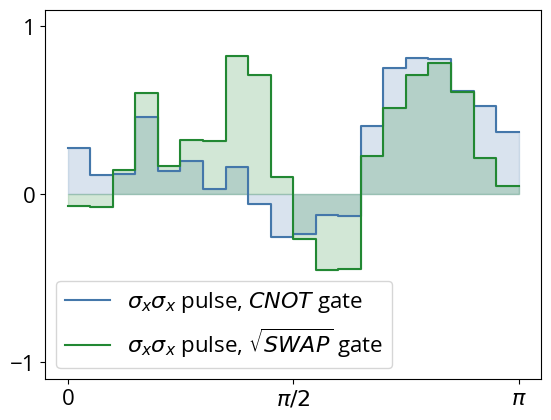

0.007163732473414952


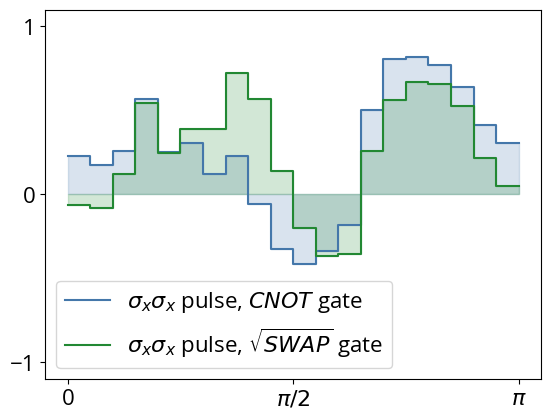

0.0020071061702808812


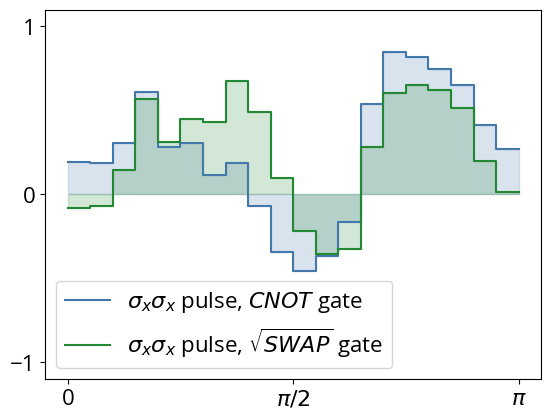

0.001175837615697839


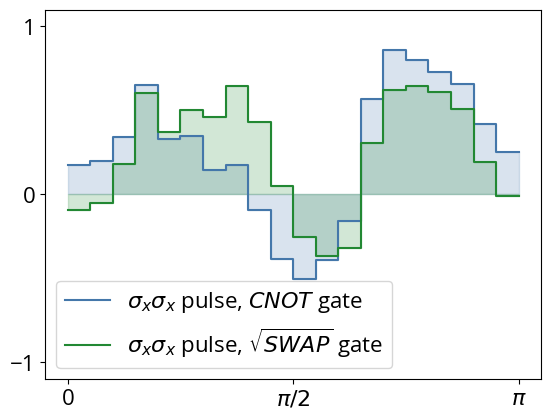

0.0006959325030978514


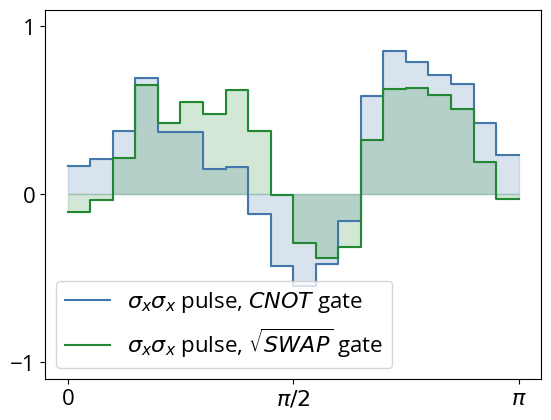

0.00046999165749916916


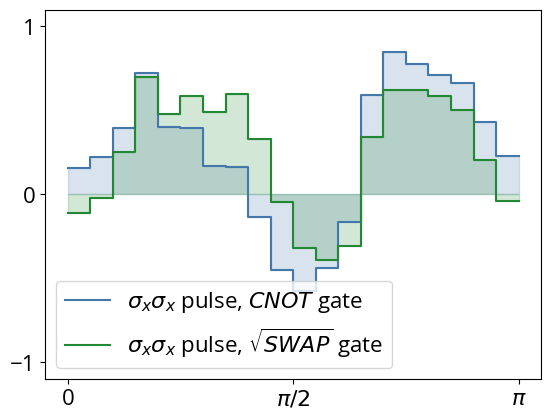

0.000307735237550566


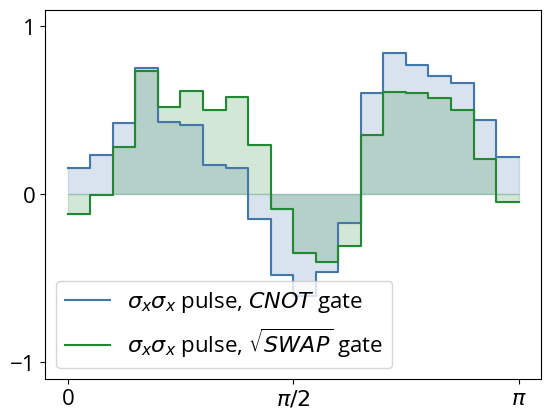

0.0002456663817050897


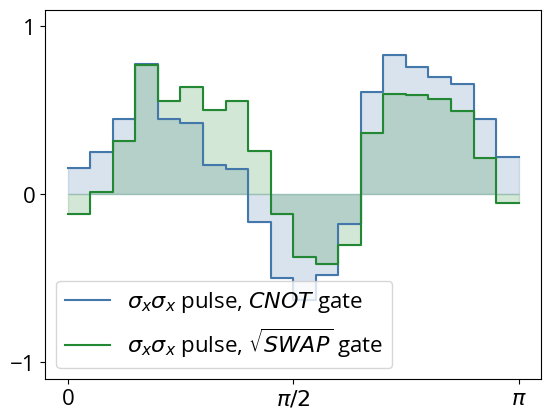

0.00018876077802487679


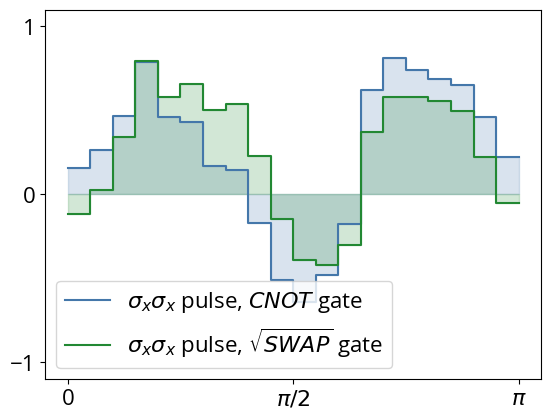

0.00011031633346580971


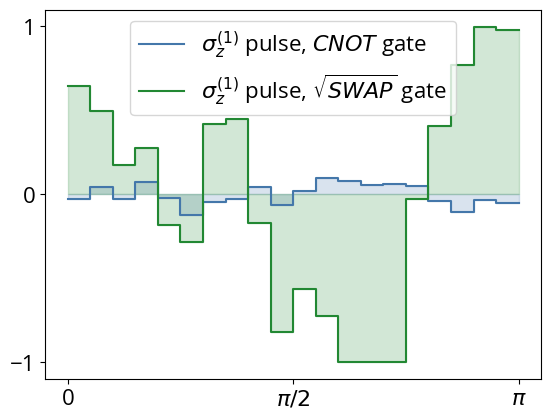

0.0386142470160189


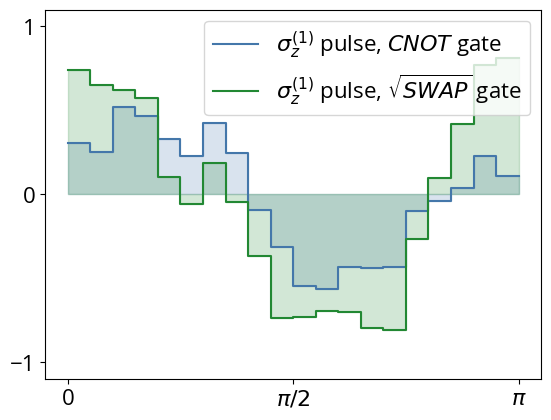

0.007163732473414952


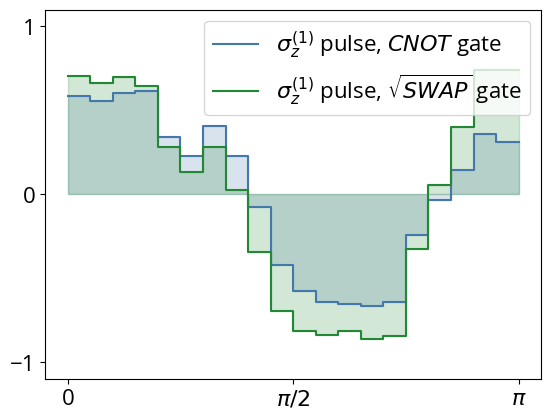

0.0020071061702808812


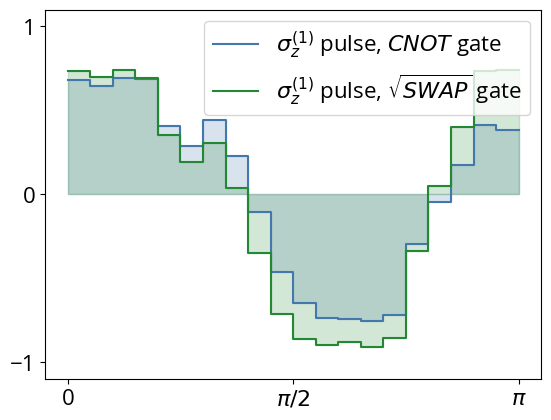

0.001175837615697839


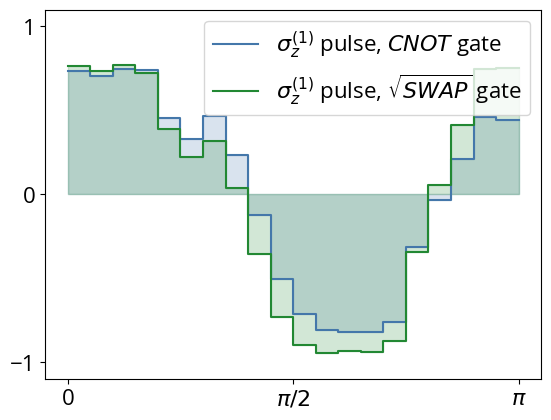

0.0006959325030978514


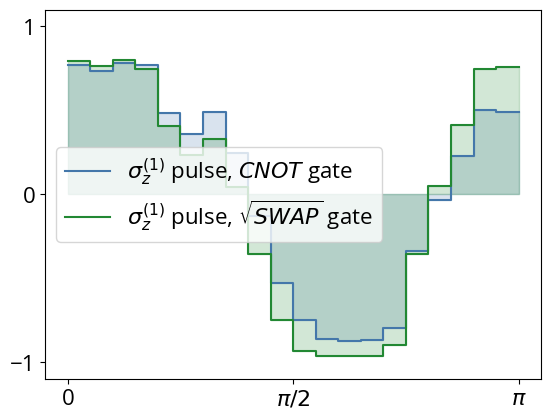

0.00046999165749916916


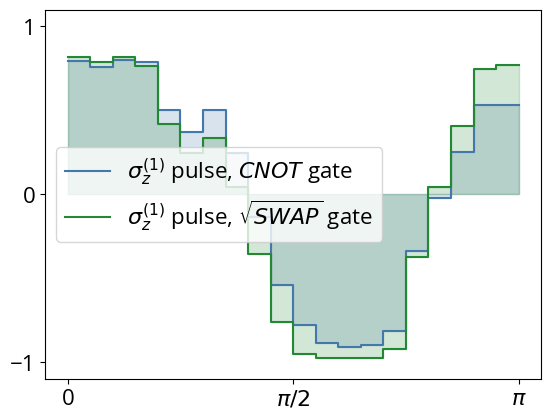

0.000307735237550566


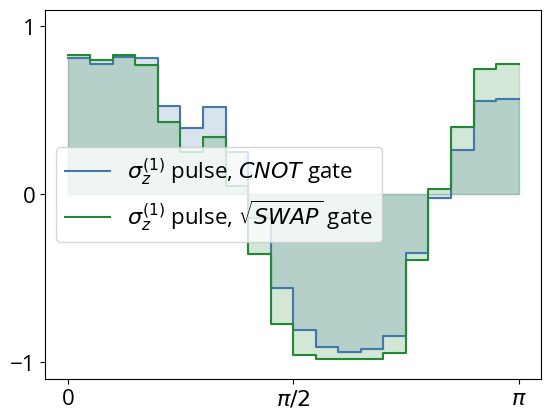

0.0002456663817050897


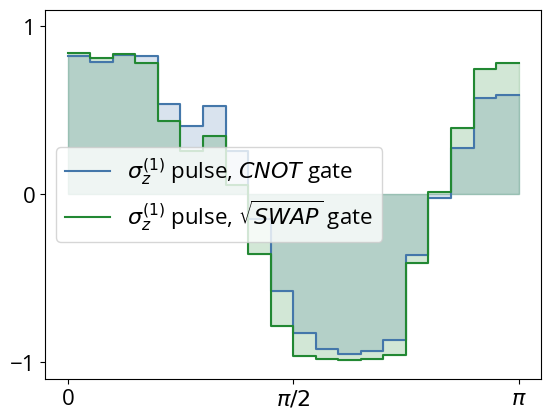

0.00018876077802487679


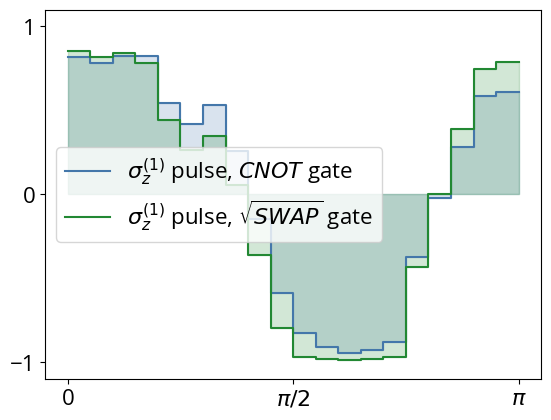

0.00011031633346580971


In [15]:
point_1 = [1/2, 0, 0]
point_2 = [1/4, 1/4, 1/4]
ctrl_idx = 0
ctrl_name = r'$\sigma_{x} \sigma_{x}$'

for i,result_dict in enumerate(result_dicts):
    points = result_dict['train_points']
    test_points = result_dict['test_points']
    opt_var_results = result_dict['opt_var_results']

    idx_1 = (point_1 == points).all(axis=1).nonzero()[0][0]
    idx_2 = (point_2 == points).all(axis=1).nonzero()[0][0]

    opt_var_results_1 = opt_var_results[idx_1][ctrl_idx]
    opt_var_results_1 = np.concatenate(([opt_var_results_1[0]], opt_var_results_1))
    opt_var_results_2 = opt_var_results[idx_2][ctrl_idx]
    opt_var_results_2 = np.concatenate(([opt_var_results_2[0]], opt_var_results_2))

    t_vals = [x*np.pi/num_pwc_segments for x in range(num_pwc_segments+1)]

    plt.step(t_vals, opt_var_results_1, color=colors[0], label=f'{ctrl_name} pulse,' + r' $CNOT$ gate')
    plt.step(t_vals, opt_var_results_2, color=colors[2], label=f'{ctrl_name} pulse,' + r' $\sqrt{SWAP}$ gate')

    plt.fill_between(t_vals,opt_var_results_1, step="pre", alpha=0.2, color=colors[0])
    plt.fill_between(t_vals,opt_var_results_2, step="pre", alpha=0.2, color=colors[2])

    # if i == 0:
    #     plt.title(f'Initial pulse shapes for nearby\nreference pulses, {ctrl_name} drive')
    # elif i == 1:
    #     plt.title(f'Pulse shapes for nearby reference pulses\nafter 1 re-optimization iteration, {ctrl_name} drive')
    # else:
    #     plt.title(f'Pulse shapes for nearby reference pulses\nafter {i} re-optimization iterations, {ctrl_name} drive')
    plt.ylim(-1.1,1.1)
    # plt.ylabel('Pulse value')
    # plt.xlabel('Time')
    plt.yticks([-1,0,1])
    plt.xticks([0,np.pi/2,np.pi], [0,r'$\pi/2$',r'$\pi$'])
    plt.legend()

    plot_file = f'interpolation_results/weyl/example_plots/{i}_pulses_{ctrl_idx}'
    os.makedirs(os.path.dirname(plot_file), exist_ok=True)
    plt.savefig(plot_file + '.pdf')
    plt.savefig(plot_file + '.svg')

    plt.show()

    avg_pt = [(point_1[i] + point_2[i])/2 for i in range(3)]
    idx_test = (avg_pt == test_points).all(axis=1).nonzero()[0][0]
    print(result_dict['infids'][idx_test])

ctrl_idx = 2
ctrl_name = r'$\sigma_z^{(1)}$'

for i,result_dict in enumerate(result_dicts):
    points = result_dict['train_points']
    opt_var_results = result_dict['opt_var_results']

    idx_1 = (point_1 == points).all(axis=1).nonzero()[0][0]
    idx_2 = (point_2 == points).all(axis=1).nonzero()[0][0]

    opt_var_results_1 = opt_var_results[idx_1][ctrl_idx]
    opt_var_results_1 = np.concatenate(([opt_var_results_1[0]], opt_var_results_1))
    opt_var_results_2 = opt_var_results[idx_2][ctrl_idx]
    opt_var_results_2 = np.concatenate(([opt_var_results_2[0]], opt_var_results_2))

    t_vals = [x*np.pi/num_pwc_segments for x in range(num_pwc_segments+1)]

    plt.step(t_vals, opt_var_results_1, color=colors[0], label=f'{ctrl_name} pulse,' + r' $CNOT$ gate')
    plt.step(t_vals, opt_var_results_2, color=colors[2], label=f'{ctrl_name} pulse,' + r' $\sqrt{SWAP}$ gate')

    plt.fill_between(t_vals,opt_var_results_1, step="pre", alpha=0.2, color=colors[0])
    plt.fill_between(t_vals,opt_var_results_2, step="pre", alpha=0.2, color=colors[2])

    plt.ylim(-1.1,1.1)
    plt.yticks([-1,0,1])
    plt.xticks([0,np.pi/2,np.pi], [0,r'$\pi/2$',r'$\pi$'])
    plt.legend()

    plot_file = f'interpolation_results/weyl/example_plots/{i}_pulses_{ctrl_idx}'
    os.makedirs(os.path.dirname(plot_file), exist_ok=True)
    plt.savefig(plot_file + '.pdf')
    plt.savefig(plot_file + '.svg')

    plt.show()

    avg_pt = [(point_1[i] + point_2[i])/2 for i in range(3)]
    idx_test = (avg_pt == test_points).all(axis=1).nonzero()[0][0]
    print(result_dict['infids'][idx_test])